https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import cpa

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')

In [3]:
adata = sc.read('../combosciplex_cpa_hvg.h5ad')  # had to save it separately bc the rank_genes_groups calculation is unique

In [4]:
adata

AnnData object with n_obs × n_vars = 63378 × 5000
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type', 'dose_val', 'cov_drug_dose_name', 'covars_comb'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'rank_genes_groups_cov', 'split_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## baseline model

Taken from Carlo's code.

In [5]:
# contains baseline prediction values for all conditions
baseline_adata = sc.read('linear_combosciplex_preds.h5ad')

In [6]:
# summary stats for above adata
df_baseline = pd.read_csv('linear_combosciplex_r2.csv')
df_baseline.columns = ['_', 'condition', 'R2_mean', 'R2_mean_DE', 'split']
df_baseline['benchmark'] = 'linear'
df_baseline

,_,condition,R2_mean,R2_mean_DE,split,benchmark
0,0,Cediranib+PCI-34051,0.934158,0.920791,test,linear
1,1,Givinostat+SRT1720,0.967357,0.959386,test,linear
2,2,Panobinostat+SRT3025,0.916869,0.795708,test,linear
3,3,Panobinostat+PCI-34051,0.946398,0.852700,test,linear
4,4,Dacinostat+PCI-34051,0.984458,0.975860,test,linear
5,5,Panobinostat+Sorafenib,0.929829,0.816322,test,linear
6,6,Panobinostat+Dasatinib,0.906944,0.783441,test,linear
7,7,Givinostat+Tanespimycin,0.985104,0.968885,test,linear
8,8,Givinostat+Carmofur,0.994569,0.995973,test,linear
9,9,Panobinostat+Crizotinib,0.897292,0.727892,test,linear


## Plot metrics

Load in CPA model and make predictions for comparison.

In [7]:
cpa_api = cpa.api.API(
    adata,
    pretrained='/home/icb/yuge.ji/projects/CPA/pretrained_models/combosciplex/model.pt',
)

Loaded pretrained model from:	/home/icb/yuge.ji/projects/CPA/pretrained_models/combosciplex/model.pt


In [8]:
# random guesses
adata_random = sc.pp.subsample(adata, n_obs=1000, copy=True)
genes_control = cpa_api.datasets['test'].subset_condition(control=True).genes
baseline_ood = cpa_api.evaluate_r2(
    cpa_api.datasets['ood'], 
    genes_control,
    adata_random.X.A
)
baseline_ood['split'] = 'ood'
baseline_ood['benchmark'] = 'baseline'

In [9]:
%%time
genes_control = cpa_api.datasets['training'].subset_condition(control=True).genes
df_train = cpa_api.evaluate_r2(cpa_api.datasets['training'].subset_condition(control=False), genes_control)
df_train['benchmark'] = 'CPA'
genes_control = cpa_api.datasets['test'].subset_condition(control=True).genes
df_ood = cpa_api.evaluate_r2(cpa_api.datasets['ood'].subset_condition(control=False), genes_control)
df_ood['benchmark'] = 'CPA'
df_test = cpa_api.evaluate_r2(cpa_api.datasets['test'].subset_condition(control=False), genes_control)
df_test['benchmark'] = 'CPA'

df_ood['split'] = 'ood'
df_test['split'] = 'test'
df_train['split'] = 'train'

CPU times: user 39 s, sys: 8.67 s, total: 47.6 s
Wall time: 8.07 s


In [39]:
df_ood.round(2).sort_values(by=['R2_mean'], ascending=False).drop(['dose_val'], axis=1)

,cell_type,condition,R2_mean,R2_mean_DE,R2_var,R2_var_DE,model,num_cells,benchmark,split
1,A549,Givinostat+Cediranib,0.99,0.98,0.97,0.49,cpa,2783,CPA,ood
3,A549,Panobinostat+SRT2104,0.99,0.99,0.98,0.93,cpa,1971,CPA,ood
0,A549,Dacinostat+Danusertib,0.97,0.94,0.93,0.19,cpa,1939,CPA,ood
4,A549,SRT2104+Alvespimycin,0.95,0.88,0.91,0.61,cpa,520,CPA,ood
2,A549,Panobinostat+Alvespimycin,0.81,0.62,0.76,0.33,cpa,996,CPA,ood


Plot.

In [10]:
import seaborn as sns

In [20]:
df = pd.concat([df_ood, df_test, df_train, df_baseline, baseline_ood], join='inner')
df[df.split != 'train'].melt(id_vars=['condition', 'benchmark', 'split'])
df = df.rename({'R2_mean': 'R2 mean', 'R2_mean_DE':'R2 mean (DEG)', 'benchmark':'model'}, axis=1)
df

,condition,R2 mean,R2 mean (DEG),model,split
0,Dacinostat+Danusertib,0.969876,0.935019,CPA,ood
1,Givinostat+Cediranib,0.988713,0.979503,CPA,ood
2,Panobinostat+Alvespimycin,0.806692,0.618525,CPA,ood
3,Panobinostat+SRT2104,0.986036,0.988538,CPA,ood
4,SRT2104+Alvespimycin,0.949929,0.883975,CPA,ood
...,...,...,...,...,...
5,Panobinostat+Alvespimycin,0.596001,-0.027083,baseline,ood
6,Panobinostat+SRT2104,0.986036,0.988538,baseline,ood
7,Panobinostat+SRT2104,0.747168,0.284542,baseline,ood
8,SRT2104+Alvespimycin,0.949929,0.883975,baseline,ood


Text(0.5, 1.0, 'OOD conditions')

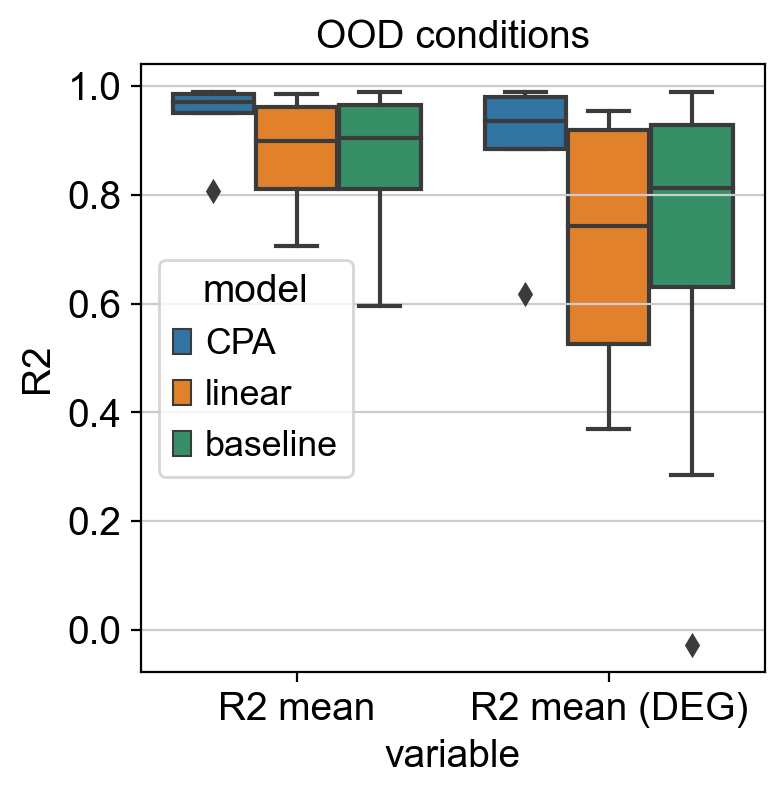

In [25]:
sns.boxplot(
    data = df[df.split == 'ood'].melt(id_vars=['condition', 'model', 'split']),
    x='variable',
    y='value',
    hue='model'
)
plt.ylabel('R2')
plt.title('OOD conditions')

## Visualize individual genes

In [26]:
genes_control = cpa_api.datasets['test'].subset_condition(control=True).genes

In [27]:
# pick the conditions to plot
treatments = adata[adata.obs.split == 'ood'].obs.condition.unique()

In [28]:
pred_adatas = []
sig_genes = {}
for cond in treatments:
    pred_adatas.append(cpa_api.predict(
        genes_control,
        cov={'cell_type': ['A549']}, 
        pert=[cond], 
        dose=['1.0+1.0'],
        return_anndata=True,
        sample=True,
        n_samples=20
    ))
    sig_genes[f"{cond.split('+')[0][0]}+{cond.split('+')[1][0]}"] = adata.uns['rank_genes_groups_cov'][f'A549_{cond}_1.0+1.0'][:2]

In [33]:
# add source label to prediction adatas
# lm_preds = ad.concat(preds)
# lm_preds.obs['source'] = '(LM)'
pred_adata = ad.concat(pred_adatas)
pred_adata.obs['source'] = '(cpa)'
ctrl = adata[adata.obs.control == 1]
ctrl.obs['source'] =  '(control)'
adata.obs['source'] = '(stim)'

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


In [101]:
# getting the x-ticks perfect
l = [pred_adata, adata[adata.obs.condition.isin(treatments)]]
for t in treatments:
    ctrl.obs['source'] = f'{t} (control)'
    l.append(ctrl.copy())
combined = ad.concat(l)
order = [
    'control+control_Givinostat+Cediranib (control)', 'Givinostat+Cediranib_(cpa)', 'Givinostat+Cediranib_(stim)',
    'control+control_Dacinostat+Danusertib (control)', 'Dacinostat+Danusertib_(cpa)', 'Dacinostat+Danusertib_(stim)',
    'control+control_Panobinostat+SRT2104 (control)', 'Panobinostat+SRT2104_(cpa)', 'Panobinostat+SRT2104_(stim)',
    'control+control_Panobinostat+Alvespimycin (control)', 'Panobinostat+Alvespimycin_(cpa)', 'Panobinostat+Alvespimycin_(stim)',
    'control+control_SRT2104+Alvespimycin (control)', 'SRT2104+Alvespimycin_(cpa)', 'SRT2104+Alvespimycin_(stim)'
]

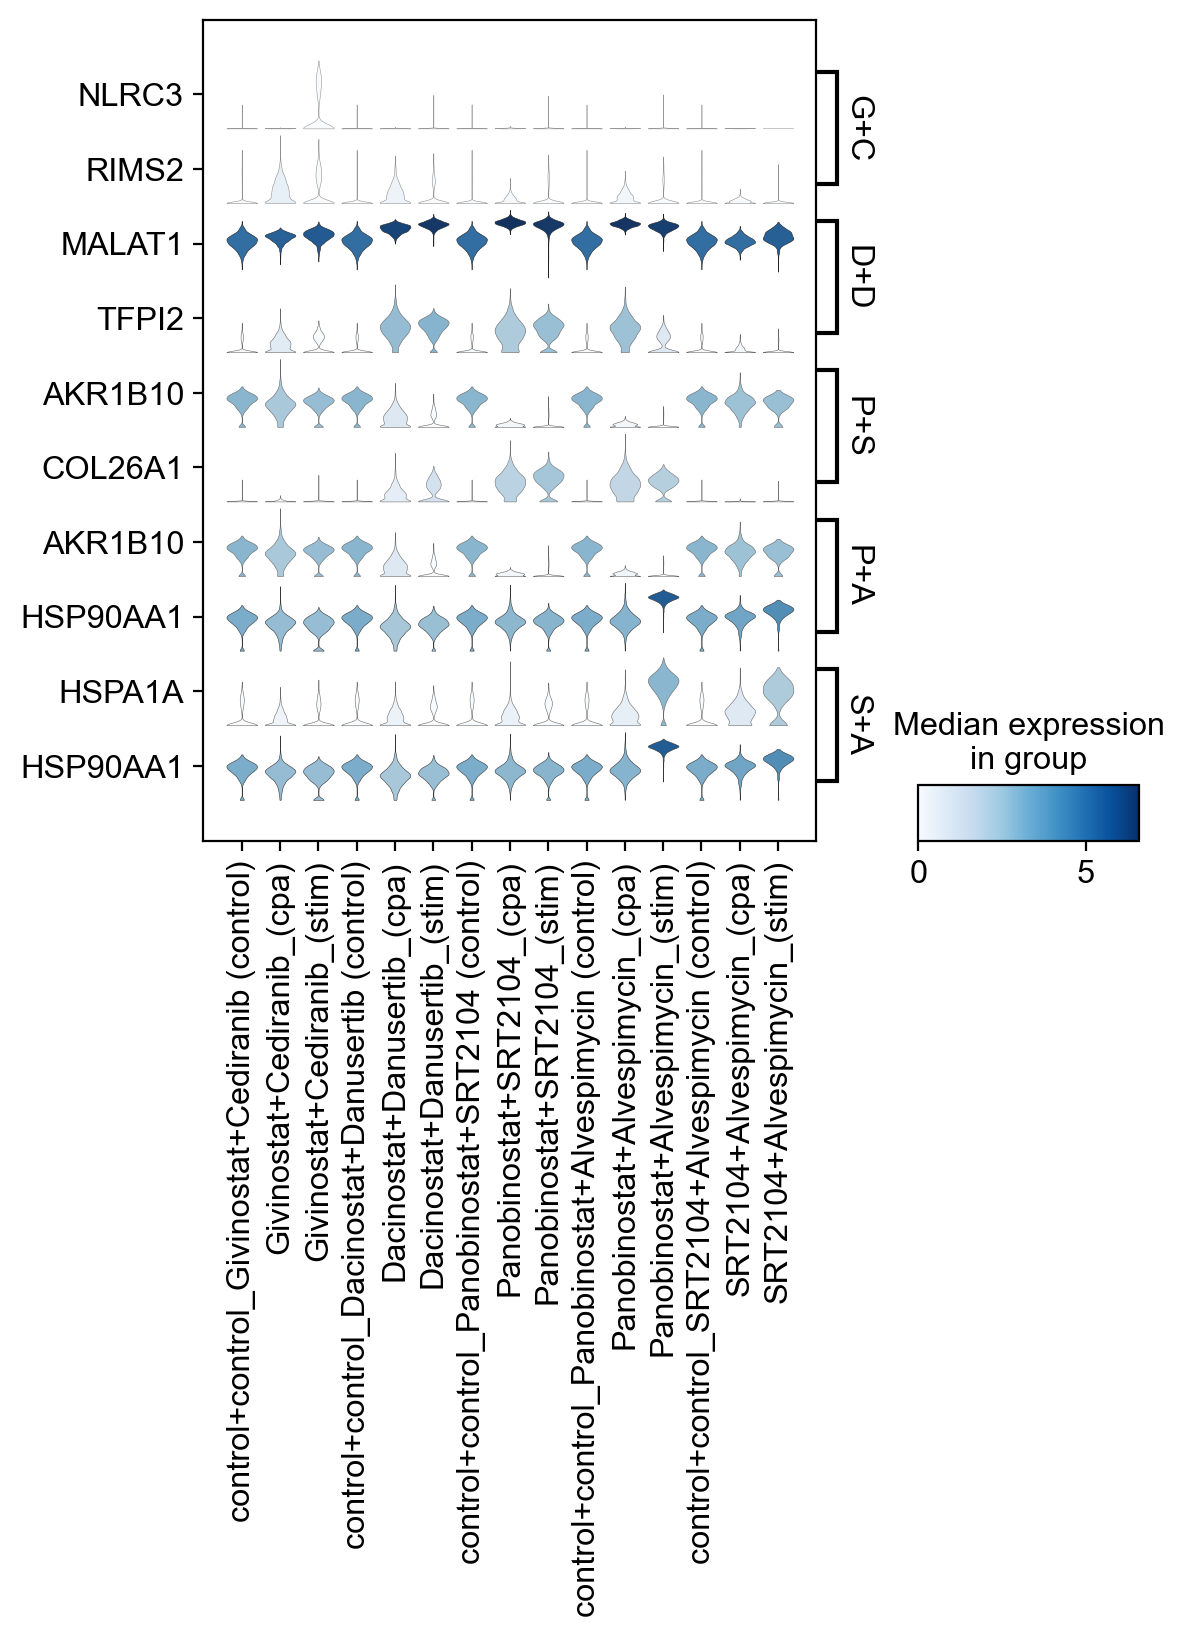

In [107]:
sc.pl.stacked_violin(
    combined,
    var_names=sig_genes, groupby=['condition', 'source'], categories_order=order, swap_axes=True, figsize=(6, 5))
# vp.set_xticklabels([i for i in range(len(order))])

## Visualize combo latent space

In [74]:
perts_anndata = cpa_api.get_drug_embeddings()
perts_anndata.obs['condition'] = perts_anndata.obs.condition.astype('category')
perts_anndata

AnnData object with n_obs × n_vars = 18 × 128
    obs: 'condition'

In [75]:
cond_dict = dict(zip(perts_anndata.obs['condition'], perts_anndata.X))

In [76]:
combos = []
for cond in adata.obs.condition.cat.categories:
    combos.append(cond_dict[cond.split('+')[0]] + cond_dict[cond.split('+')[1]])

In [77]:
combo_adata = ad.AnnData(X=np.array(combos))
combo_adata.obs['condition'] = adata.obs.condition.cat.categories

for cond in perts_anndata.obs.condition.cat.categories:
    combo_adata.obs[f'{cond}'] = ['Yes' if cond in c else 'No' for c in combo_adata.obs.condition.values]

combo_adata

AnnData object with n_obs × n_vars = 32 × 128
    obs: 'condition', 'Alvespimycin', 'Carmofur', 'Cediranib', 'Crizotinib', 'Curcumin', 'Dacinostat', 'Danusertib', 'Dasatinib', 'Givinostat', 'PCI-34051', 'Panobinostat', 'Pirarubicin', 'SRT1720', 'SRT2104', 'SRT3025', 'Sorafenib', 'Tanespimycin', 'control'

In [78]:
sc.pp.neighbors(combo_adata)
sc.tl.umap(combo_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'Alvespimycin' as categorical
... storing 'Carmofur' as categorical
... storing 'Cediranib' as categorical
... storing 'Crizotinib' as categorical
... storing 'Curcumin' as categorical
... storing 'Dacinostat' as categorical
... storing 'Danusertib' as categorical
... storing 'Dasatinib' as categorical
... storing 'Givinostat' as categorical
... storing 'PCI-34051' as categorical
... storing 'Panobinostat' as categorical
... storing 'Pirarubicin' as categorical
... storing 'SRT1720' as categorical
... storing 'SRT2104' as categorical
... storing 'SRT3025' as categorical
... storing 'Sorafenib' as categorical
... storing 'Tanespimycin' as categorical
... storing 'control' as categorical


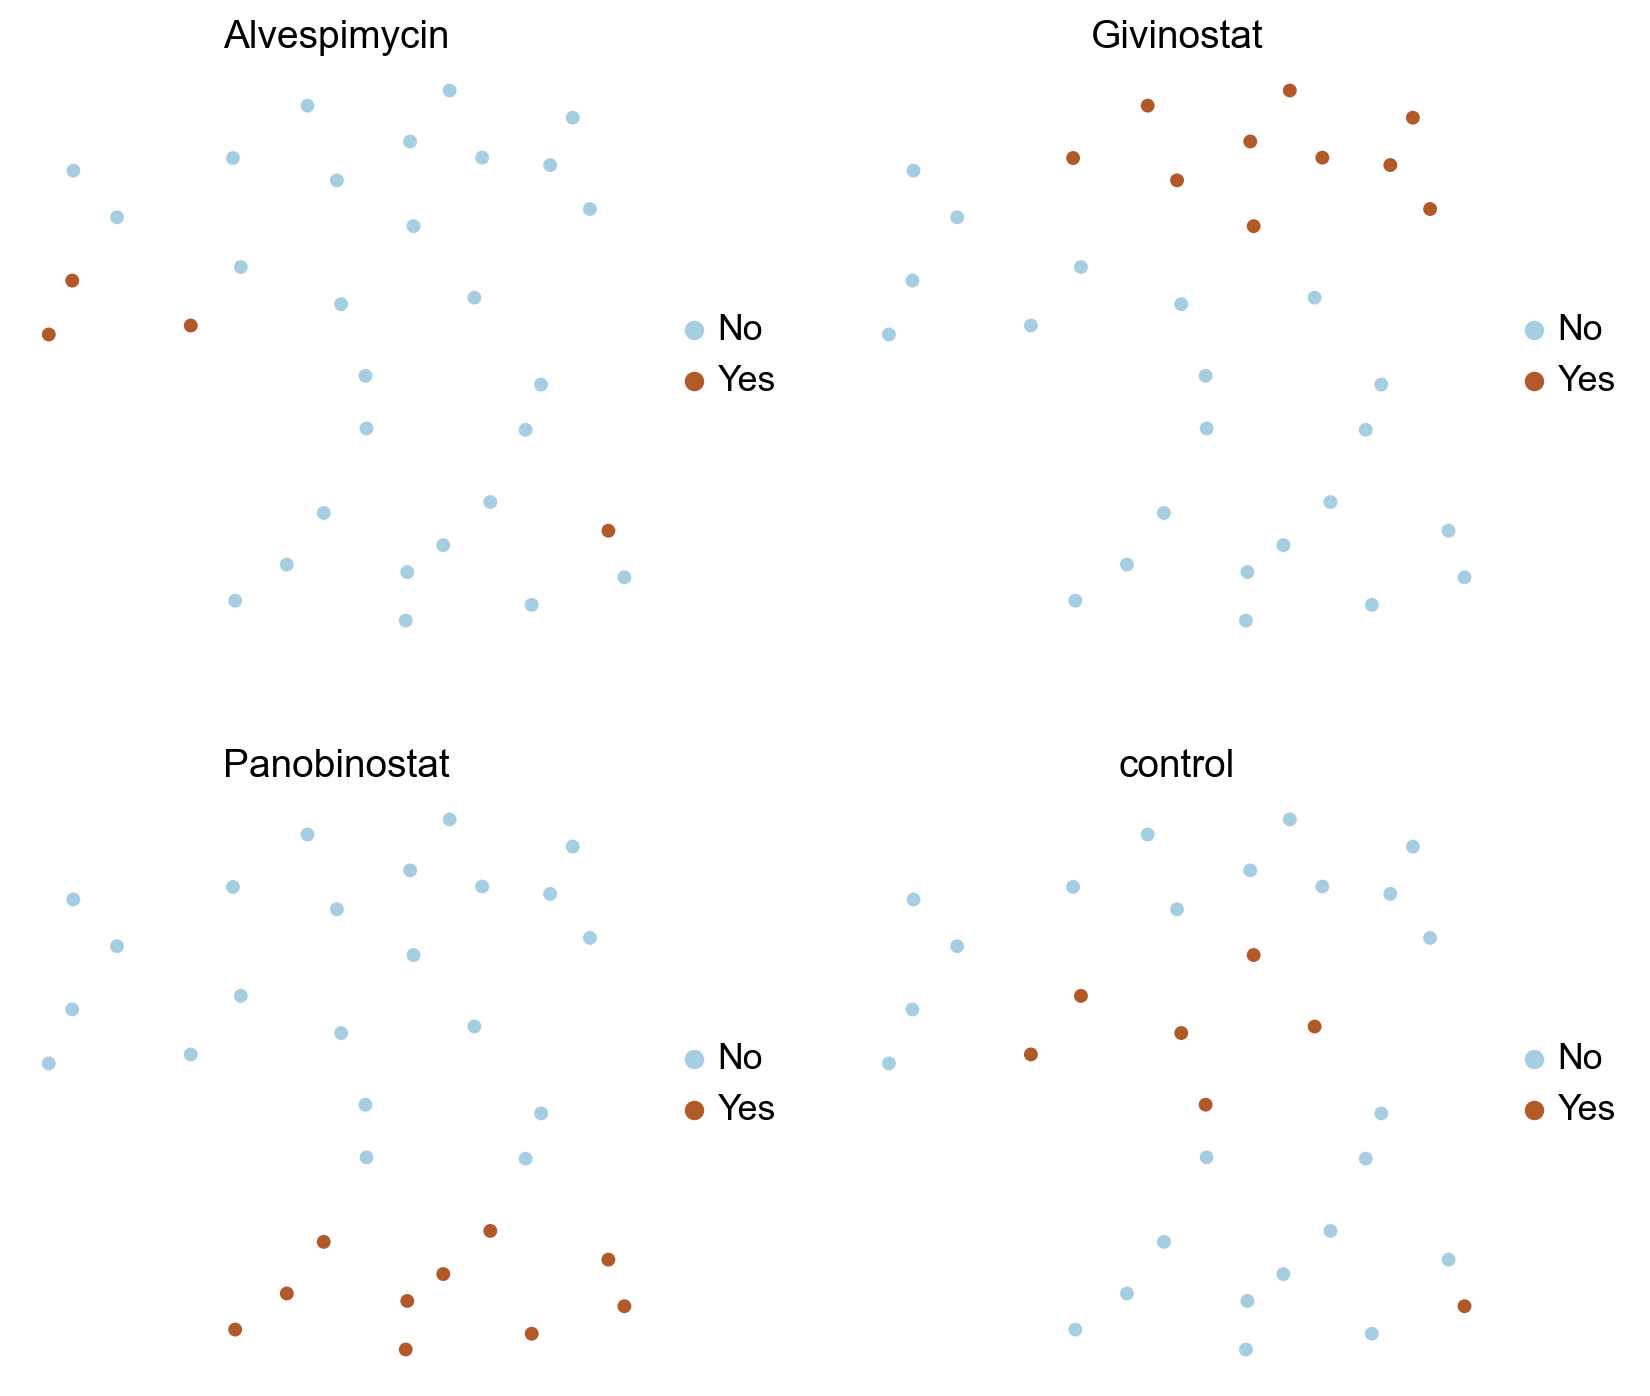

In [79]:
sc.pl.umap(combo_adata, size=100, color=['Alvespimycin', 'Givinostat', 'Panobinostat', 'control'], ncols=2, palette='Paired')

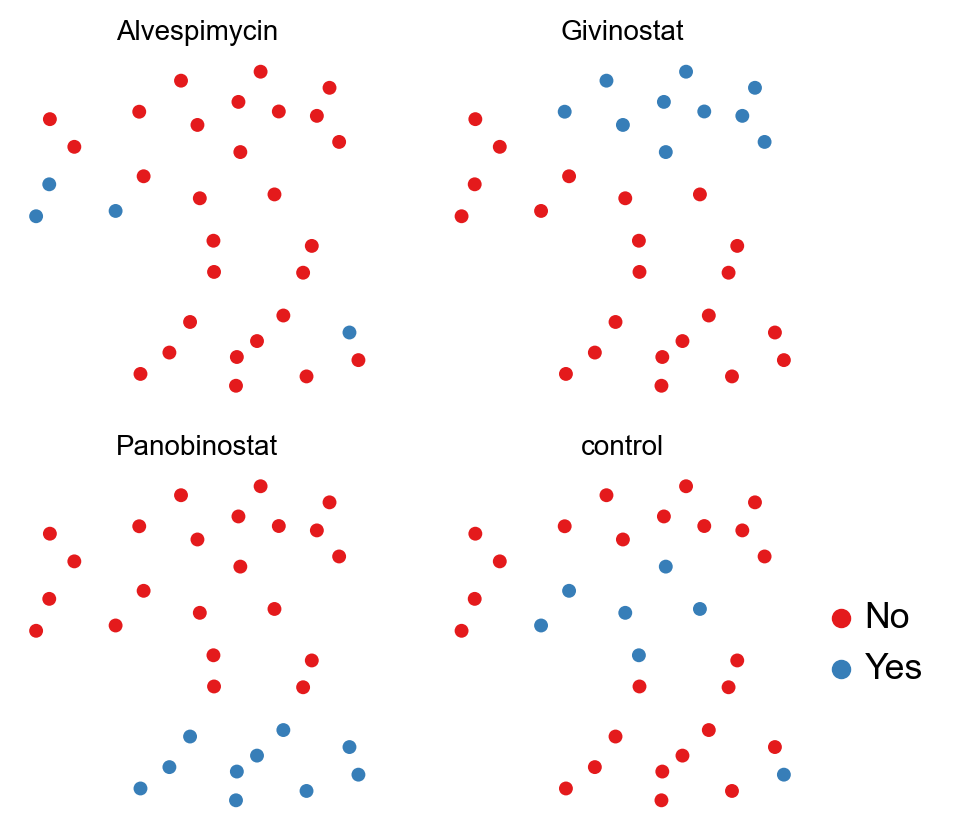

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
ax = ax.flatten()

for i, d in enumerate(
    ['Alvespimycin', 'Givinostat', 'Panobinostat', 'control']
):
    sc.pl.umap(
        combo_adata, 
        size=100,
        color=d,
        palette=sns.color_palette('Set1'),
        show=False,
        ax=ax[i],
    )
    ax[i].set_title(d, fontsize=10)
    if i != 3:
        ax[i].get_legend().remove()
fig.savefig('fig3_f.png', bbox_inches='tight', dpi=500)